# Basic Diffusion World Model

This notebook implements a simple WM like my old pokemon demo from https://madebyoll.in/posts/game_emulation_via_dnn/, here using a more-modern multi-frame-conditioned IADB latent diffusion model similar to GameNGen (https://arxiv.org/abs/2408.14837).

## Config

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import random
from collections import namedtuple
from pathlib import Path
from functools import lru_cache

import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm import tqdm

th.backends.cudnn.benchmark = True

In [26]:
class Config:
    device = "cuda" if th.cuda.is_available() else "cpu"
    channels = 4
    hw = 32
    full_hw = hw * 8
    shape = (channels, 24, 32)
    n_past = 4

def show(x):
    if not isinstance(x, th.Tensor) or x.ndim == 4:
        x = th.cat(tuple(x), -1)
    display(TF.to_pil_image(x))

## Dataset Downloading

In [31]:
# mixed python/bash cell so we can see intermediate output; pure bash cell doesn't display incrementally
dataset_dir = "pokemon_dataset"
if not Path(dataset_dir).exists():
    !mkdir -p {dataset_dir}
    for i in [1, 2, 3]:
        !echo "Getting video" {i}
        !wget -nc https://github.com/madebyollin/game-emulation-via-neural-network-dataset/raw/refs/heads/main/video_{i}.mp4 -O {dataset_dir}/video_{i}.mp4
        !wget -nc https://github.com/madebyollin/game-emulation-via-neural-network-dataset/raw/refs/heads/main/video_{i}.txt -O {dataset_dir}/video_{i}.txt
        !mkdir {dataset_dir}/video_{i}.frames && ffmpeg -i {dataset_dir}/video_{i}.mp4 {dataset_dir}/video_{i}.frames/"%05d.png"
        !echo "Added" $(find {dataset_dir}/video_{i}.frames/ -iname "*.png" | wc -l) "frames from video" {i}
print("done")

done


# Dataset Preprocessing

In [32]:
!wget -nc -nv https://github.com/madebyollin/taesd/raw/main/taesd.py
!wget -nc -nv https://github.com/madebyollin/taesd/raw/main/taesd_encoder.pth
!wget -nc -nv https://github.com/madebyollin/taesd/raw/main/taesd_decoder.pth

In [33]:
from taesd import TAESD
taesd = TAESD().to(Config.device)

In [34]:
class PreprocessingDataset(th.utils.data.Dataset):
    def __init__(self, p):
        self.ims = sorted(list(p.glob("*.jpg")) + list(p.glob("*.png")))
    def __len__(self):
        return len(self.ims)
    def __getitem__(self, i):
        return TF.pil_to_tensor(Image.open(self.ims[i])), i

In [35]:
def scale_latents(x):
    return x.mul(0.25).add(0.5).clamp(0, 1)
def unscale_latents(x):
    return x.sub(0.5).div(0.25)

@th.no_grad()
def preprocess_dataset(in_path, out_path):
    in_path, out_path = Path(in_path), Path(out_path)
    if out_path.exists():
        print(f"dataset '{out_path}' already preprocessed; skipping...")
        return
    dataloader = th.utils.data.DataLoader(PreprocessingDataset(in_path), batch_size=16, num_workers=2)
    out_path.mkdir(exist_ok=True)
    for x, x_idx in tqdm(dataloader):
        with th.amp.autocast("cuda"):
            x_latent = taesd.encoder(x.to(Config.device).div(255.0))
            x_latent = scale_latents(x_latent).clamp_(0, 1).mul_(255).round_().byte().cpu()
        for x_latent_j, j in zip(x_latent, x_idx):
            TF.to_pil_image(x_latent_j).save(out_path / f"{j.item():06d}.png")
for frame_path in sorted(list(Path("pokemon_dataset").glob("*.frames"))):
    print("Preprocessing", frame_path)
    preprocess_dataset(frame_path, frame_path.with_suffix(".latents"))

Preprocessing pokemon_dataset/video_1.frames
dataset 'pokemon_dataset/video_1.latents' already preprocessed; skipping...
Preprocessing pokemon_dataset/video_2.frames
dataset 'pokemon_dataset/video_2.latents' already preprocessed; skipping...
Preprocessing pokemon_dataset/video_3.frames
dataset 'pokemon_dataset/video_3.latents' already preprocessed; skipping...


# Dataset Loading

In [37]:
CONTROL_NAME_TO_IDX = dict(
    NO_ACTION=0,
    UP=1,
    LEFT=2,
    DOWN=3,
    RIGHT=4,
)

def load_im(path):
    return TF.pil_to_tensor(Image.open(path))

def parse_label(label_line):
    frame, control = label_line.strip().split(" ")
    sprint = 0
    if "SPRINT_" in control:
        control, sprint = control.replace("SPRINT_", ""), 1
    return frame, CONTROL_NAME_TO_IDX[control], sprint

Sample = namedtuple("Sample", ("past", "future", "control", "control_sprint"))

class LatentControlDataset(th.utils.data.Dataset):
    def __init__(self, p):
        self.videos = []
        self.frame_paths = []
        self.images = []
        for label_path in sorted(list(Path(p).glob("*.txt"))):
            with label_path.open() as labels:
                self.videos.append([parse_label(l) for l in labels])
                self.frame_paths.append(label_path.with_suffix(".latents"))
                # preload everything in memory, latents are tiny
                # print("preloading frames for", label_path)
                # self.images.append([load_im(label_path.with_suffix(".latents") / frame) for frame, _ in self.videos[-1]])
    def __len__(self):
        return sum(len(v) for v in self.videos)
    def load_image(self, video_idx, frame_idx):
        if self.images:
            return self.images[video_idx][frame_idx]
        else:
            frame_path = self.frame_paths[video_idx] / self.videos[video_idx][frame_idx][0]
            return load_im(frame_path)
    def __getitem__(self, i):
        video_idx = 0
        while i >= len(self.videos[video_idx]):
            i -= len(self.videos[video_idx])
            video_idx += 1
        frame_idx = i
        assert i < len(self.videos[video_idx])
        future_frame = self.load_image(video_idx, frame_idx)
        frames = []
        control, sprint = self.videos[video_idx][frame_idx][1:]
        # randomly mask past sometimes so we learn to initialize with no memory
        # TODO: this mask should sometimes apply to only the oldest N frames
        past_is_dropped_out = random.random() < 0.1
        n_dropped_frames = random.randint(1, Config.n_past) if past_is_dropped_out else 0
        # load past frames; i iterates oldest-to-newest
        for i in range(Config.n_past):
            frame_idx_i = frame_idx - Config.n_past + i
            if frame_idx_i < 0 or i < n_dropped_frames:
                frame = th.zeros_like(future_frame)
            else:
                frame = self.load_image(video_idx, frame_idx_i)
            frames.append(frame)
        return Sample(th.cat(frames, 0), future_frame, control, sprint)

d_train = LatentControlDataset("pokemon_dataset")
_ = d_train[0] # test loading a frame

In [38]:
def to_device(xb):
    past = unscale_latents(xb.past.to(Config.device, non_blocking=True) / 255.0)
    future = unscale_latents(xb.future.to(Config.device, non_blocking=True) / 255.0)
    control = xb.control.to(Config.device, non_blocking=True).view(-1, 1, 1, 1)
    control_sprint = xb.control_sprint.to(Config.device, non_blocking=True).view(-1, 1, 1, 1)
    return Sample(past, future, control, control_sprint)

Dataset has 18646 samples.
Input Past Latents (Timesteps stacked vertically)


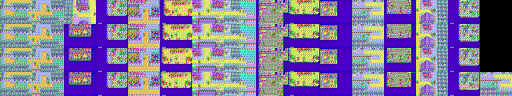

Input controls
[0 0 0 0 3 4 0 0 0 0 0 4 1 0 1 4]
Input sprint flag
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
Target Next-Frame Latents


In [45]:
def demo_dataset(dataset, n=16):
    print(f"Dataset has {len(dataset)} samples.")
    samples = to_device(next(iter(th.utils.data.DataLoader(dataset, shuffle=True, batch_size=n))))
    print(f"Input Past Latents (Timesteps stacked vertically)")
    show(scale_latents(th.cat(samples.past.split(4, dim=1), -2))[:, :3])
    print("Input controls")
    print(samples.control.flatten().cpu().numpy())
    print("Input sprint flag")
    print(samples.control_sprint.flatten().cpu().numpy())
    print(f"Target Next-Frame Latents")
    show(scale_latents(samples.future[:, :3]))
demo_dataset(d_train)

## Model

In [50]:
Prediction = namedtuple("Prediction", ("pred_target"))

def zero_init(m):
    nn.init.zeros_(m.weight.data)
    return m

def conv_act(n_in, n_out, **kwargs):
    conv = nn.Conv2d(n_in, n_out, 3, padding=1, **kwargs)
    return nn.Sequential(conv, nn.ReLU(inplace=True))

def conv_bn_act(n_in, n_out, **kwargs):
    kwargs["bias"] = False
    conv = nn.Conv2d(n_in, n_out, 3, padding=1, **kwargs)
    return nn.Sequential(conv, nn.BatchNorm2d(n_out), nn.ReLU(inplace=True))

def plain_conv(n_in, n_out, **kwargs):
    return nn.Conv2d(n_in, n_out, 3, padding=1, bias=False, **kwargs)

class Block(nn.Module):
    def __init__(self, n_f):
        super().__init__()
        self.conv = nn.Sequential(
            conv_bn_act(n_f, n_f),
            conv_bn_act(n_f, n_f),
            conv_bn_act(n_f, n_f),
            conv_bn_act(n_f, n_f),
        )
        self.proj = nn.Sequential(
            nn.Conv2d(n_f * 2, n_f, 1), nn.ReLU(inplace=True),
            zero_init(plain_conv(n_f, n_f)),
        )

    def forward(self, x):
        return self.proj(th.cat([x, self.conv(x)], 1)) + x


def blocks(n_f, n_b):
    return nn.Sequential(*[Block(n_f) for _ in range(n_b)])


def enc(n_in, n_out, n_b):
    return nn.Sequential(nn.AvgPool2d(2), blocks(n_out, n_b))

def dec(n_f, n_b):
    return nn.Sequential(
        blocks(n_f, n_b),
        nn.Upsample(scale_factor=2),
    )

class UNet(nn.Module):
    def __init__(self, n_f=[128, 128, 128, 128], n_b=1, n_io=Config.channels, n_ctx=Config.n_past*Config.channels + len(CONTROL_NAME_TO_IDX)):
        super().__init__()
        self.n_ctrls = len(CONTROL_NAME_TO_IDX)
        self.cat = nn.Sequential(plain_conv(n_io + 1 + n_ctx, n_f[0]), blocks(n_f[0], n_b))
        self.enc = nn.ModuleList(enc(a, b, n_b) for a, b in zip(n_f, n_f[1:]))
        self.mid = blocks(n_f[-1], n_b)
        self.dec = nn.ModuleList(
            nn.Sequential(nn.Conv2d(a + b, a, 1, bias=False), dec(a, n_b))
            for a, b in zip(n_f[1:], n_f[2:] + n_f[-1:])
        )
        self.end = nn.Sequential(
            nn.Conv2d(n_f[0] + n_f[1], n_f[0], 1, bias=False),
            blocks(n_f[0], n_b),
            zero_init(plain_conv(n_f[0], n_io)),
        )

    def forward(self, x_noisy, noise_level, past, control, control_sprint):
        skips = []
        control = F.one_hot(control.view((control.shape[0],)), num_classes=len(CONTROL_NAME_TO_IDX)).unsqueeze(-1).unsqueeze(-1) * (1 + control_sprint)
        x = self.cat(th.cat([x_noisy, noise_level.expand(x_noisy[:, :1].shape), past, control.expand(*control.shape[:2], *x_noisy.shape[-2:])], 1))
        for enc in self.enc:
            skips.append(x)
            x = enc(x)
        x = th.cat([x, self.mid(x)], 1)
        for dec in reversed(self.dec):
            x = th.cat([dec(x), skips.pop()], 1)
        x = self.end(x)
        return Prediction(x)

model = UNet().to(Config.device)

def weight_average(w_prev, w_new, n):
    alpha = min(0.95, n / 10)
    return alpha * w_prev + (1-alpha) * w_new

avg_model = th.optim.swa_utils.AveragedModel(model, avg_fn=weight_average)

In [51]:
@th.no_grad()
def demo_model(model, n=16):
    model.eval()
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {n_parameters / 1e6:.1f} million trainable parameters.")
    x = th.rand(n, *Config.shape, device=Config.device)
    past = th.rand(n, Config.n_past*Config.channels, *Config.shape[-2:], device=Config.device)
    control = th.randint(0, len(CONTROL_NAME_TO_IDX), size=(n, 1, 1, 1), device=Config.device)
    control_sprint = th.rand(n, 1, 1, 1, device=Config.device)
    noise_level = th.rand(n, 1, 1, 1, device=Config.device)
    y = model(x, noise_level, past, control, control_sprint)
    print(f"Here are some model outputs on random noise:")
    show(scale_latents(y.pred_target)[:, :3].clamp(0, 1))
    model.train()
demo_model(model)

Model has 7.1 million trainable parameters.
Here are some model outputs on random noise:


## Image Generation

In [52]:
@th.no_grad()
def generate_images(model, n_images=4, n_steps=25, return_latents=False, latent_shape=Config.shape, generator=None, past=None, control=None, control_sprint=None):
    model.eval()
    x = th.randn(n_images, *latent_shape, device=Config.device, generator=generator)
    noise_levels = th.linspace(1, 0, n_steps + 1, device=Config.device)
    for nl_in, nl_out in zip(noise_levels, noise_levels[1:]):
        x = x + (nl_in - nl_out) * model(x, nl_in.view(1, 1, 1, 1), past, control=control, control_sprint=control_sprint).pred_target
    model.train()
    if return_latents: return x
    return taesd.decoder(x).clamp(0, 1)

Here are some generated latents (for an untrained model, they will be empty squares)


Here are some generated images (for an untrained model, they will be empty squares)


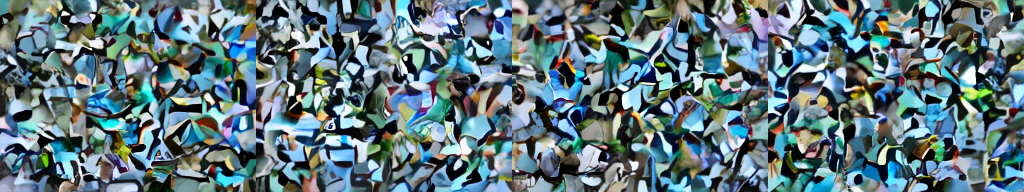

In [54]:
def demo_image_generation(model):
    print("Here are some generated latents (for an untrained model, they will be empty squares)")
    past = unscale_latents(th.zeros(16, Config.n_past*Config.channels, 24, 32, device=Config.device))
    control = th.randint(0, len(CONTROL_NAME_TO_IDX), size=(16, 1, 1, 1), device=Config.device)
    control_sprint = th.rand(16, 1, 1, 1, device=Config.device)
    show(scale_latents(generate_images(avg_model, n_images=16, return_latents=True, past=past, control=control, control_sprint=control_sprint)[:, :3]))
    print("Here are some generated images (for an untrained model, they will be empty squares)")
    show(generate_images(avg_model, n_images=4, past=past[:4], control=control[:4], control_sprint=control_sprint[:4]))
demo_image_generation(avg_model)

## Training

In [55]:
import os
import datetime
import time
from IPython.display import clear_output
from collections import defaultdict

class DotDict(dict):
    __getattr__ = dict.__getitem__

class Visualizer:
    def __init__(self, baseline_path):
        self.smoothed_loss = None
        self.losses_since_last_vis = []
        self.avg_losses = []
        self.steps = []
        self.step = 0
        self.t_last_vis = 0
        self.t_last_save = 0
        self.t_start = None
        self.baseline_path = baseline_path
        folder, idx = datetime.datetime.now().strftime("%Y_%m_%d") + "_training_logs", 0
        while Path(f"{folder}_{idx}").exists():
            idx += 1
        self.folder = Path(f"{folder}_{idx}")
        self.folder.mkdir()
    def __call__(self, model, t, r, loss, n_demo=16, prof=None):
        self.losses_since_last_vis.append(loss)
        self.smoothed_loss = loss if self.smoothed_loss is None else 0.99 * self.smoothed_loss + 0.01 * loss
        self.step += 1
        if self.t_start is None:
            self.t_start = t
        if t > self.t_last_vis + 30:
            generator = th.Generator(device=Config.device).manual_seed(1337)
            generated_latents = generate_images(avg_model, n_images=n_demo, past=r.x.past[:n_demo], control=r.x.control[:n_demo], control_sprint=r.x.control_sprint[:n_demo], return_latents=True, generator=generator)
            generated_images = taesd.decoder(generated_latents[:n_demo//4]).clamp(0, 1)
            generator = th.Generator(device=Config.device).manual_seed(1337)
            clear_output(wait=True)
            print("Input (Noisified image, Noise level, Last frame of past context)")
            show(scale_latents(r.noisy_future)[:n_demo, :3])
            show(r.noise_level.expand(len(r.noise_level), 3, 16, Config.hw)[:n_demo])
            show(scale_latents(r.noisy_past)[:n_demo, -4:-1])
            show(taesd.decoder(r.noisy_past[:, -4:][:n_demo//4]).clamp(0, 1))
            print("Predictions")
            show(scale_latents(r.y.pred_target)[:n_demo, :3])
            show(scale_latents(r.target)[:n_demo, :3])
            self.steps.append(self.step)
            self.avg_losses.append(sum(self.losses_since_last_vis) / len(self.losses_since_last_vis))
            self.losses_since_last_vis = []
            print("Generated Latents (From Averaged Model)")
            show(scale_latents(generated_latents)[:, :3])
            print("Generated Images (From Averaged Model)")
            show(generated_images)
            print("Target Images")
            show(taesd.decoder(r.x.future[:n_demo//4]).clamp(0, 1))
            plt.title("Losses")
            plt.plot(self.steps, self.avg_losses, label=f"Current Run {self.folder.name} ({self.avg_losses[-1]:.5f})")
            plt.gcf().set_size_inches(16, 4)
            plt.ylim(0, 1.5 * self.avg_losses[-1])
            if self.baseline_path is not None:
                baseline_steps, baseline_losses = th.load(self.baseline_path + "/stats.pth")
                n = len(self.steps)
                plt.plot(baseline_steps[:n], baseline_losses[:n], label=f"Baseline {Path(self.baseline_path).name} ({baseline_losses[:n][-1]:.5f})", alpha=0.4, color="C4")
                plt.legend()
            if t > self.t_last_save + 120:
                th.save(model.state_dict(), self.folder / "model.pth")
                th.save((self.steps, self.avg_losses), self.folder / "stats.pth")
                TF.to_pil_image(th.cat(tuple(scale_latents(generated_latents)[:, :3]), -1)).save(self.folder / f"generated_latents_{self.step:07d}.jpg", quality=95)
                TF.to_pil_image(th.cat(tuple(generated_images), -1)).save(self.folder / f"generated_{self.step:07d}.jpg", quality=95)
                plt.gcf().savefig(self.folder / "stats.jpg")
                self.t_last_save = t
            plt.show()
            print(prof)
            self.t_last_vis = t
        print(
            f"\r{self.step: 5d} Steps; {int(t - self.t_start): 3d} Seconds; "
            f"{60 * self.step / (t - self.t_start + 1):.1f} Steps / Min; "
            f"{len(r.x.future) * 60 * self.step / (t - self.t_start + 1):.1f} Images / Min; "
            f"Loss {loss:.5f}; "
            f"Smoothed Loss {self.smoothed_loss:.5f}; "
        , end="")

class Looper(th.utils.data.Dataset):
    def __init__(self, dataset, n=1<<20):
        self.dataset = dataset
        self.n = n
    def __len__(self):
        return max(len(self.dataset), self.n)
    def __getitem__(self, i):
        return self.dataset[i % len(self.dataset)]

class TrackContext:
    def __init__(self, k, prof):
        self.k = k
        self.prof = prof
    def __enter__(self):
        self.prof.tick(self.k)
    def __exit__(self, *args):
        self.prof.tock(self.k)

class TinyProfiler:
    def __init__(self):
        self.t = {}
        self.r = defaultdict(list)
        self.sep = '/'
    def tick(self, k):
        self.t[k] = time.time();
    def tock(self, k):
        if k not in self.t:
            raise ValueError()
        elapsed = time.time() - self.t[k]
        self.r[k].append(elapsed)
    def __call__(self, k):
        return TrackContext(k, self)
    def mean(self, x):
        return sum(x) / len(x)
    def __repr__(self):
        return "Timing:\n"+ "\n".join(f"{'  ' * k.count(self.sep)}{k.split(self.sep)[-1].ljust(16)}: \033[34m{1000 * self.mean(self.r[k][-10:]):0.1f}\033[0m\033[37mms\033[0m" for k in sorted(self.r))

class Trainer:
    def __init__(self, model, avg_model, dataset, batch_size=64, use_amp=True, baseline_path=None):
        self.model = model
        self.avg_model = avg_model
        self.last_avg_time = time.time()
        self.opt = th.optim.Adam(model.parameters(), 3e-4, betas=(0.9, 0.95))
        self.amp = use_amp
        self.scaler = th.amp.GradScaler("cuda", enabled=self.amp)
        num_workers = min(8, len(os.sched_getaffinity(0)) if hasattr(os, "sched_getaffinity") else os.cpu_count())
        self.dataloader = th.utils.data.DataLoader(Looper(dataset), batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers, pin_memory=True)
        self.dl_iter = iter(self.dataloader)
        self.visualizer = Visualizer(baseline_path)
        self.prof = TinyProfiler()

    def avg_model_step(self, t):
        if t > self.last_avg_time + 1:
            self.avg_model.update_parameters(self.model)
            self.last_avg_time = t

    def get_batch(self):
        try:
            batch = next(self.dl_iter)
        except StopIteration:
            self.dl_iter = iter(self.dataloader)
            batch = next(self.dl_iter)
        return to_device(batch)

    def train(self, n_seconds):
        self.model.train()
        start_time = time.time()
        t_prev_visualize = start_time
        while time.time() < start_time + n_seconds:
            t_now = time.time()
            should_visualize = t_now > t_prev_visualize + 1
            if should_visualize:
                t_prev_visualize = t_now
            self.train_step(t_now)

    def train_step(self, t, should_visualize=True):
        with self.prof("get_batch"):
            x = self.get_batch()
        with self.prof("forward"), th.amp.autocast(device_type=Config.device, enabled=self.amp):
            noise, noise_level = th.randn_like(x.future), th.rand_like(x.future[:,:1,:1,:1])
            noisy_future = noise_level * noise + (1-noise_level) * x.future
            past_noise_level = th.rand_like(x.future[:,:1,:1,:1]) * 0.05 # past noise augmentation to avoid drift
            noisy_past = past_noise_level * th.randn_like(x.past) + (1 - past_noise_level) * x.past
            y = self.model(noisy_future, noise_level, past=noisy_past, control=x.control, control_sprint=x.control_sprint)
            target = x.future - noise # IADB (flow) target
            loss = F.mse_loss(y.pred_target, target)
        with self.prof("backward"):
            self.opt.zero_grad(); self.scaler.scale(loss).backward(); self.scaler.step(self.opt); self.scaler.update(); self.avg_model_step(t)
        with self.prof("visualizer"):
            if should_visualize:
                res = DotDict(
                    x=x,
                    y=y,
                    noise=noise,
                    noise_level=noise_level,
                    noisy_future=noisy_future,
                    past_noise_level=past_noise_level,
                    noisy_past=noisy_past,
                    target=target
                )
                self.visualizer(self.avg_model.module, t, res, loss.item(), prof=self.prof)

trainer = Trainer(model, avg_model, d_train)

Input (Noisified image, Noise level, Last frame of past context)


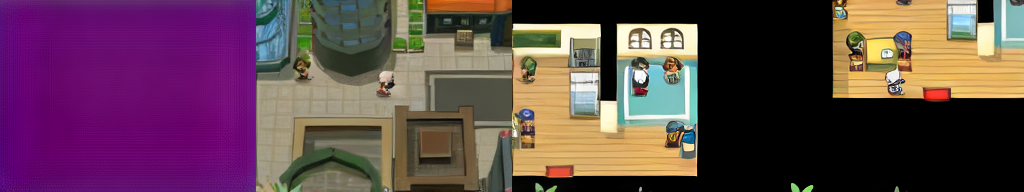

Predictions


Generated Latents (From Averaged Model)


Generated Images (From Averaged Model)


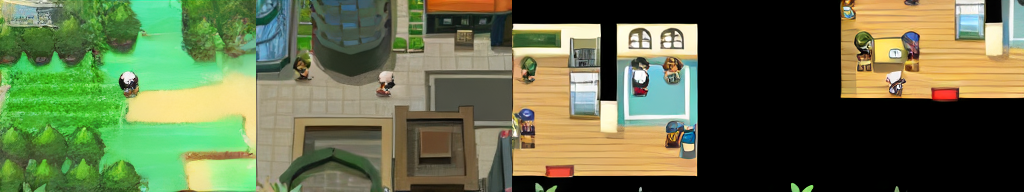

Target Images


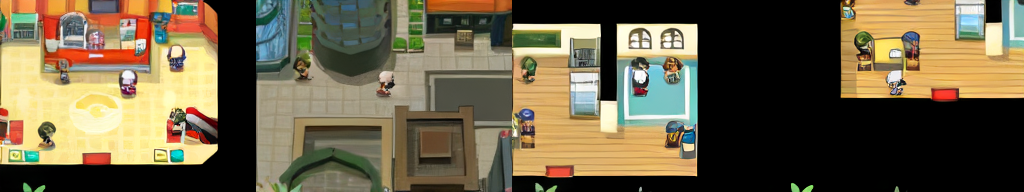

In [ ]:
trainer.train(n_seconds=60*60)

#  Rollout Demos (with random controls - interactive version TODO)

In [ ]:
import io
import base64
from IPython.display import HTML, clear_output
import time

def frames_to_html_gif(frames):
    """Display TCHW [0, 1] frame tensor as inline video on colab."""
    if isinstance(frames, th.Tensor):
        assert frames.ndim == 4 and frames.shape[1] == 3 # TCHW
        frames = [TF.to_pil_image(f) for f in frames.clamp_(0, 1).mul_(255).round_().byte().cpu()]
    video_buff = io.BytesIO()
    frames[0].save(video_buff, append_images=frames[1:], save_all=True, duration_ms=1000/30, loop=0, format="GIF")
    video_buff.seek(0)
    video_b64 = base64.b64encode(video_buff.getvalue()).decode('utf-8')
    return HTML(f"<img src='data:image/gif;base64,{video_b64}'/>")

def key_to_control(k):
    if k == " ": v, s = CONTROL_NAME_TO_IDX["NO_ACTION"], 0
    elif k == "w": v, s = CONTROL_NAME_TO_IDX["UP"], 0
    elif k == "a": v, s = CONTROL_NAME_TO_IDX["LEFT"], 0
    elif k == "s": v, s = CONTROL_NAME_TO_IDX["DOWN"], 0
    elif k == "d": v, s = CONTROL_NAME_TO_IDX["RIGHT"], 0
    elif k == "W": v, s = CONTROL_NAME_TO_IDX["UP"], 1
    elif k == "A": v, s = CONTROL_NAME_TO_IDX["LEFT"], 1
    elif k == "S": v, s = CONTROL_NAME_TO_IDX["DOWN"], 1
    elif k == "D": v, s = CONTROL_NAME_TO_IDX["RIGHT"], 1
    else:
        raise ValueError(f"key [{k}] not recognized")
    return th.ones(1, 1, 1, 1, dtype=th.long) * v, th.ones(1, 1, 1, 1) * s

# closed loop demo
@th.no_grad()
def demo_rollout(model, rollout_length=64):
    # past memory is filled with zeros
    mem = [unscale_latents(th.zeros(1, *Config.shape, device=Config.device)) for i in range(Config.n_past)]
    key = " "
    im_handle = None
    rollout_frames = []
    # do a short rollout with random controls
    for i in range(rollout_length):
        if random.random() < 0.25:
            key = random.choice(" " * 4 + "wasd" * 4 + "WASD")
        control, sprint = key_to_control(key)
        latent = generate_images(model, n_images=1, n_steps=(50 if i == 0 else 8), return_latents=True, past=th.cat(mem[-Config.n_past:], 1), control=control.to(Config.device), control_sprint=sprint.to(Config.device))
        frame = taesd.decoder(latent)
        frame_im = TF.to_pil_image(frame[0].clamp(0, 1))
        mem.append(latent)
        mem.pop(0)
        if im_handle is not None:
            im_handle.update(frame_im)
        else:
            im_handle = display(frame_im, display_id=True)
        print(f"Frame \033[35m{i+1}/{rollout_length}\033[0m Control [\033[34m{key}\033[0m]" + " " * 10, end="\r")
        rollout_frames.append(frame_im)
    print()
    print("Done with rollout. Saving GIF.")
    im_handle.update(frames_to_html_gif(rollout_frames))

n_rollouts = 5
for rollout_idx in range(n_rollouts):
    display(HTML(f"<h2>Rollout {rollout_idx+1}/{n_rollouts}</h2>"))
    demo_rollout(avg_model.module)